 # Notebook description

In this notebook data is explored, prepared and then then analyzed, specifically the delay of the plane departure from 'flight' table.

 Libraries import and loading enviroment variables

In [65]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from dotenv import load_dotenv
from os import environ
import plotly.express as px
import numpy as np
import statistics


In [66]:
dotenv_path = '../.env'
load_dotenv(dotenv_path)

True

In [67]:
username = environ.get('db_username')
password = environ.get('db_password')

host = environ.get('db_host')
database = environ.get('db_database')
port = environ.get('db_port')

Creating connection variables 

In [68]:
url = URL.create(
    "postgresql",
    username=username,
    password=password,
    host=host,
    database=database,
)
engine = create_engine(url)

Creating function that loads data from database table into dataframe

In [69]:
def read_sql_table(tablename):
    return pd.read_sql(f'select * from {tablename}', engine)

 # Loading data into workspace

In [70]:
flight_df_raw = read_sql_table('flight')
flight_df_raw.head()

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,crs_elapsed_time,actual_elapsed_time,distance,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,205.0,204.0,1199.0,5,NaN,NaN,NaN,NaN,NaN,2019
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,210.0,205.0,1199.0,5,NaN,NaN,NaN,NaN,NaN,2019
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,210.0,220.0,1199.0,5,4.0,0.0,10.0,0.0,3.0,2019
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,205.0,204.0,1199.0,5,NaN,NaN,NaN,NaN,NaN,2019
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,120.0,124.0,581.0,3,NaN,NaN,NaN,NaN,NaN,2019


Changing the name of the column

In [71]:
flight_df_raw.rename(columns = {'dep_delay_new': 'dep_delay'}, inplace = True)
flight_df_raw.columns

Index(['id', 'month', 'day_of_month', 'day_of_week', 'op_unique_carrier',
       'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
       'crs_dep_time', 'dep_time', 'dep_delay', 'dep_time_blk', 'crs_arr_time',
       'arr_time', 'arr_delay_new', 'arr_time_blk', 'cancelled',
       'crs_elapsed_time', 'actual_elapsed_time', 'distance', 'distance_group',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'year'],
      dtype='object')

Deleting flights from 2020 as there is only data for first three months

In [72]:
flight_df = flight_df_raw.copy()
flight_df = flight_df.loc[
    (flight_df_raw['year'] != 2020) &
    (flight_df_raw['cancelled'] != 1)
]

Calculating the descriptive statistics of 'dep_delay' column

In [73]:
dep_delay_statistics_df = flight_df['dep_delay'].describe([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(2)
dep_delay_statistics_df

count    1095742.00
mean          14.77
std           46.49
min            0.00
10%            0.00
25%            0.00
50%            0.00
75%            8.00
90%           42.00
95%           81.00
99%          206.00
max         1959.00
Name: dep_delay, dtype: float64

The difference between 99th percentile and maximal value suggest that there's need to cut the highest 5 % from the analysis

 # Creating histogram of the departure values

Plot with all the data from 'dep_delay' column with bins of the size 10

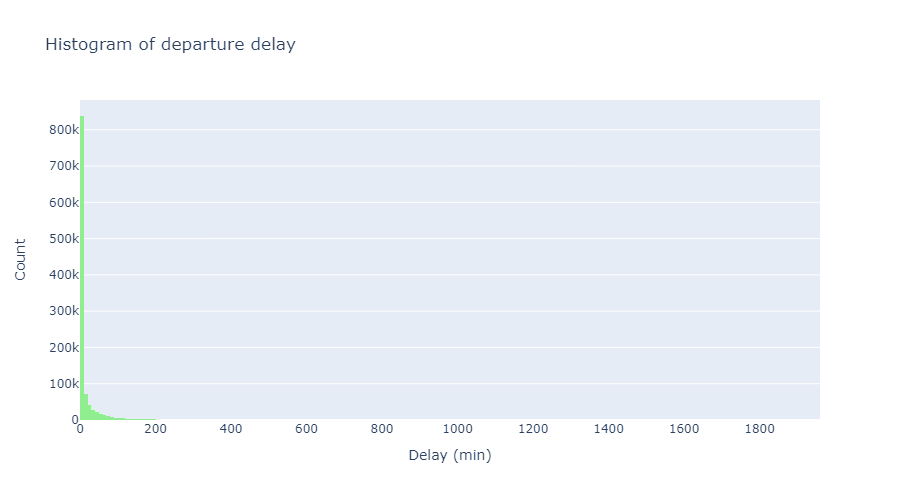

In [74]:
fig_dd = px.histogram(flight_df,
                      x='dep_delay',
                      title='Histogram of departure delay',
                      width=900,
                      height = 500,
                      color_discrete_sequence = ['lightgreen'])
fig_dd.update_layout(xaxis_title="Delay (min)", yaxis_title="Count")
fig_dd.update_traces(xbins=dict(
        start=0,
        end=max(flight_df['dep_delay']),
        size=10))     

fig_dd.show('png')

The above plot is not easy readable so there's need to delete rows where 'dep_delay' equals 0 as there's too many of them 

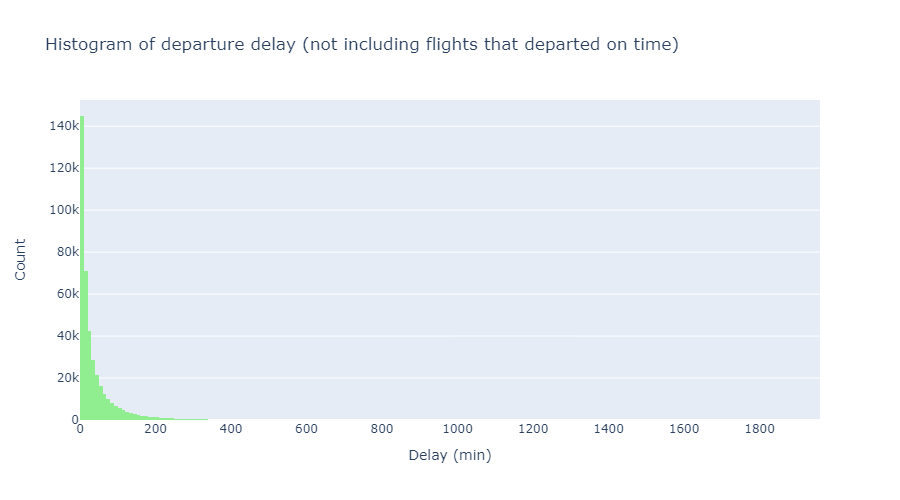

In [75]:
flight_df_temp = flight_df.loc[
    flight_df['dep_delay'] > 0
]

fig_dd_over_0 = px.histogram(flight_df_temp,
                      x='dep_delay',
                      title='Histogram of departure delay (not including flights that departed on time)',
                      width=900,
                      height = 500,
                      color_discrete_sequence = ['lightgreen'])
fig_dd_over_0.update_layout(xaxis_title="Delay (min)", yaxis_title="Count")
fig_dd_over_0.update_traces(xbins=dict(
        start=0,
        end=max(flight_df['dep_delay']),
        size=10))                    
fig_dd_over_0.show('png')

Second plot is a little bit better but still doesn't tell anything particular. In the next step a plot is made with rows with 'dep_delay' greater than 0 and 'dep_delay' smaller than 95th percentile 

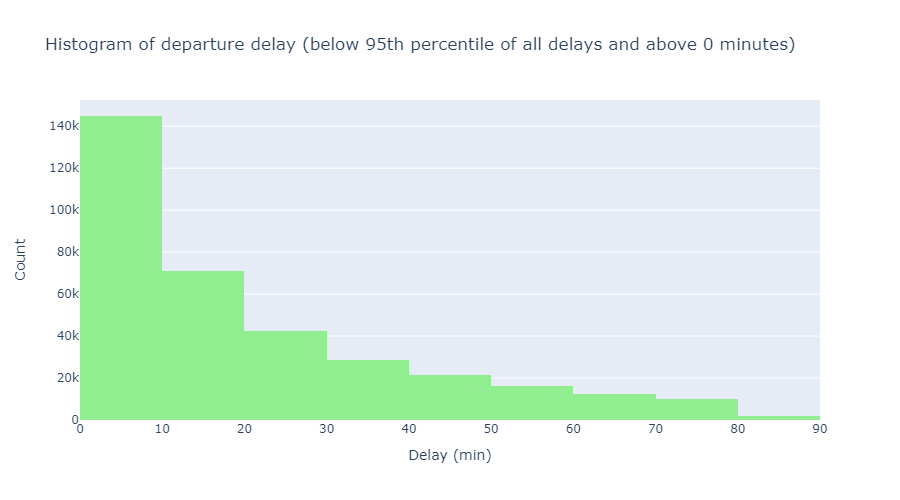

In [76]:
flight_df_temp = flight_df.loc[
    (flight_df['dep_delay'] > 0) &
    (flight_df['dep_delay'] <= np.percentile(flight_df['dep_delay'], 95))
]

fig_dd_over_0_below_95 = px.histogram(flight_df_temp,
                      x='dep_delay',
                      title='Histogram of departure delay (below 95th percentile of all delays and above 0 minutes)',
                      width=900,
                      height = 500,
                      color_discrete_sequence = ['lightgreen'])
fig_dd_over_0_below_95.update_layout(xaxis_title="Delay (min)", yaxis_title="Count")
fig_dd_over_0_below_95.update_traces(xbins=dict(
        start=0,
        end=max(flight_df['dep_delay']),
        size=10))                    
fig_dd_over_0_below_95.show('png')

Last histogram shows that most of the delays are no longer that 20 minutes 

 # Delays analysis


As delay under 15 minutes could be considered too low for people to care, in the next step 'is_delayed' column is created, which is a boolean column that equals 1 when the plane is delayed over 15 minutes

In [77]:
flight_df['is_delayed'] = np.where(flight_df['dep_delay'] > 15, 1, 0)
flight_df.head()

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,actual_elapsed_time,distance,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,is_delayed
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,204.0,1199.0,5,NaN,NaN,NaN,NaN,NaN,2019,0
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,205.0,1199.0,5,NaN,NaN,NaN,NaN,NaN,2019,0
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,220.0,1199.0,5,4.0,0.0,10.0,0.0,3.0,2019,0
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,204.0,1199.0,5,NaN,NaN,NaN,NaN,NaN,2019,0
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,124.0,581.0,3,NaN,NaN,NaN,NaN,NaN,2019,0


In [78]:
delayed_ratio = round(statistics.mean(flight_df['is_delayed']), 2)
delayed_ratio

0.19

Delayed ratio equals 19% so on average out of every 100 flights 19 are delayed 15 min or over

 # Delays vs month

In this section a plot is created that determines how delays ratio changes through different months

Grouping delays per month 

In [79]:
flight_df_delays = flight_df.loc[:,['month', 'is_delayed']]

flight_delays_by_month_df = flight_df_delays.groupby('month').mean().reset_index()
flight_delays_by_month_df['is_delayed'] = round(flight_delays_by_month_df['is_delayed'] * 100, 2)
flight_delays_by_month_df

,month,is_delayed
0,1,18.08
1,2,21.86
2,3,17.61
3,4,18.28
4,5,20.47
5,6,24.76
6,7,21.67
7,8,21.03
8,9,14.77
9,10,16.35


Creating a barplot of delays grouped by month 

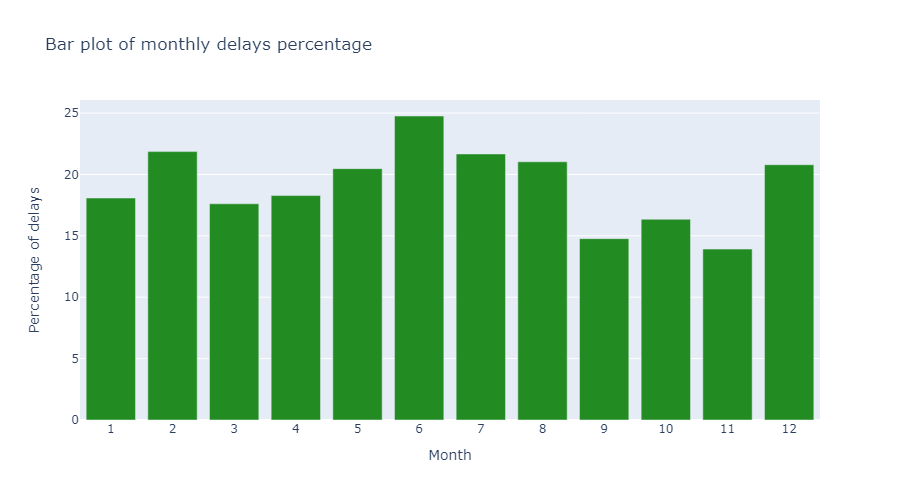

In [80]:
fig_id_month = px.bar(flight_delays_by_month_df,
                      x='month',
                      y = 'is_delayed',
                      title='Bar plot of monthly delays percentage',
                      width=900,
                      height = 500,
                      color_discrete_sequence = ['forestgreen'])
fig_id_month.update_xaxes(dtick='month')
fig_id_month.update_layout(xaxis_title="Month", yaxis_title="Percentage of delays")
fig_id_month.show('png')

The last plot shows that delys ratio doesn't change much throughout the months but is little bit higher in holiday season (summer - 5, 6, 7, 8, winter - 1, 2, 12)

 # Delays vs day of the week

In this section a plot is created that determines how delays ratio changes through different days of the week

Grouping delays by days of the week

In [81]:
flight_df_delays = flight_df.loc[:,['day_of_week', 'is_delayed']]

flight_delays_by_weekday_df = flight_df_delays.groupby('day_of_week').mean().reset_index()
flight_delays_by_weekday_df['is_delayed'] = round(flight_delays_by_weekday_df['is_delayed'] * 100, 2)
flight_delays_by_weekday_df

,day_of_week,is_delayed
0,1,20.13
1,2,17.48
2,3,18.28
3,4,21.22
4,5,20.32
5,6,16.78
6,7,19.24


Creating a barplot of delays grouped by days of the week

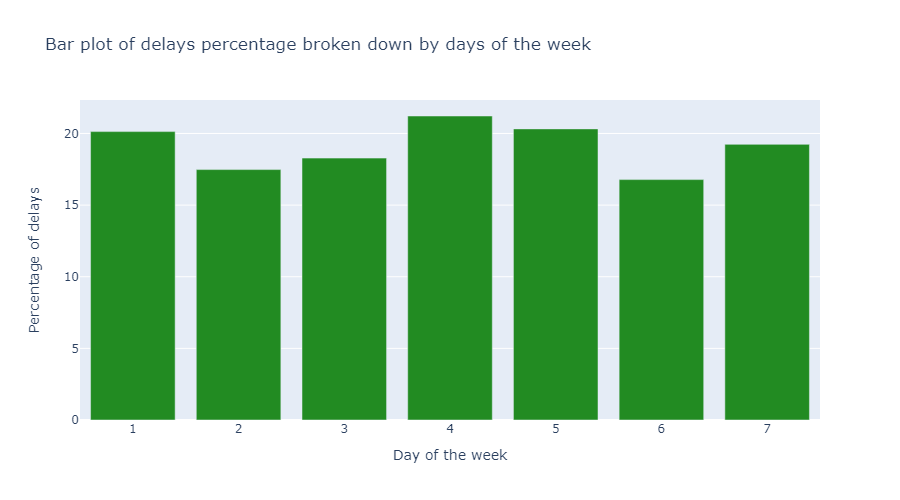

In [82]:
fig_id_weekday = px.bar(flight_delays_by_weekday_df,
                      x='day_of_week',
                      y = 'is_delayed',
                      title='Bar plot of delays percentage broken down by days of the week',
                      width=900,
                      height = 500,
                      color_discrete_sequence = ['forestgreen'])
fig_id_weekday.update_xaxes(dtick='day_of_week')
fig_id_weekday.update_layout(xaxis_title="Day of the week", yaxis_title="Percentage of delays")
fig_id_weekday.show('png')

The last plot doesn't show the influence day of the week has on flight delay

 # Delays vs weekend

In this section a plot is created that determines how delays ratio changes between week days and weekend

Creating new boolean column 'is_weekend' that equals 1 if the flight was on Saturday or Sunday

In [83]:
flight_df['is_weekend'] = np.where(flight_df['day_of_week'] > 5, 1, 0)
flight_df.tail()

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,distance,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,is_delayed,is_weekend
1382982,1382967,12,11,3,DL,N321DH,1826,13303,10397,1807,...,594.0,3,NaN,NaN,NaN,NaN,NaN,2019,0,0
1382983,1382968,12,11,3,DL,N329NW,1982,13303,12953,1959,...,1096.0,5,5.0,0.0,19.0,0.0,0.0,2019,1,0
1382984,1382969,12,11,3,DL,N331NW,1987,13303,10397,1125,...,594.0,3,NaN,NaN,NaN,NaN,NaN,2019,0,0
1382985,1382970,12,11,3,DL,N309DN,2151,13303,12953,700,...,1096.0,5,0.0,0.0,66.0,0.0,0.0,2019,1,0
1382986,1382971,12,11,3,DL,N338DN,2405,13303,10397,1231,...,594.0,3,NaN,NaN,NaN,NaN,NaN,2019,0,0


Aggregation of data to a new dataframe

In [84]:
flight_df_delays = flight_df.loc[:,['is_weekend', 'is_delayed']]

flight_delays_by_weekend_df = flight_df_delays.groupby('is_weekend').mean().reset_index()
flight_delays_by_weekend_df['is_delayed'] = round(flight_delays_by_weekend_df['is_delayed'] * 100, 2)
flight_delays_by_weekend_df

,is_weekend,is_delayed
0,0,19.49
1,1,18.12


Creating a barplot that shows if the delays ratio changes on the weekend

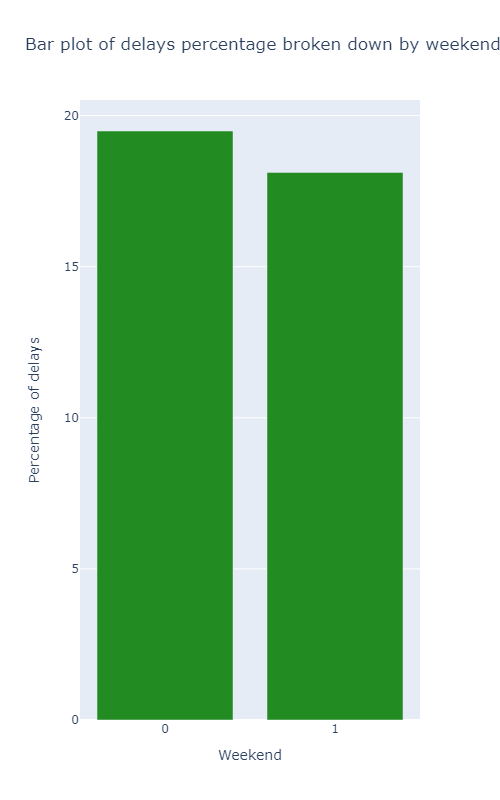

In [85]:
fig_id_weekend = px.bar(flight_delays_by_weekend_df,
                      x='is_weekend',
                      y = 'is_delayed',
                      title='Bar plot of delays percentage broken down by weekend and weekdays',
                      width=500,
                      height = 800,
                      color_discrete_sequence = ['forestgreen'])
fig_id_weekend.update_layout(xaxis_title="Weekend", yaxis_title="Percentage of delays")
fig_id_weekend.update_xaxes(dtick = 'is_weekend')
fig_id_weekend.show('png')

Flight being on the weekend doesn't affect flight delays

 # Delays vs flight distance

 In this section analysis is made on the influence that flight distance has on flight delay

Calculating descriptive statistics of 'distance' column

In [86]:
flight_distance_analysis_df = flight_df['distance'].describe([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(2)
flight_distance_analysis_df

count    1095742.00
mean         758.08
std          600.43
min          100.00
10%          216.00
25%          337.00
50%          606.00
75%          937.00
90%         1721.00
95%         2475.00
99%         2586.00
max         2586.00
Name: distance, dtype: float64

Creating scatterplot of 10000 random rows

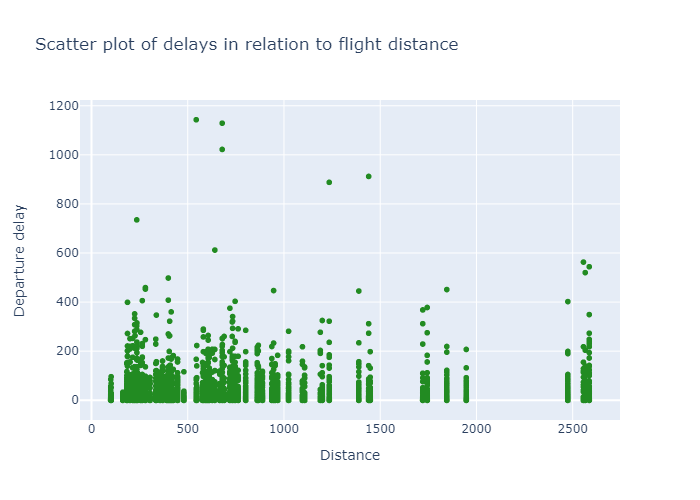

In [87]:
fig_distance_delay = px.scatter(flight_df.sample(10000),
                      x='distance',
                      y = 'dep_delay',
                      title='Scatter plot of delays in relation to flight distance',
                      color_discrete_sequence = ['forestgreen'])
fig_distance_delay.update_layout(xaxis_title="Distance", yaxis_title="Departure delay")
fig_distance_delay.show('png')

Because in almost every random 10000 rows there are outliers the analysis has to be made for observations are lower than 95th percentile

In [88]:
flight_df = flight_df.loc[
    flight_df['distance'] <= np.percentile(flight_df['distance'], 95)
]

Creating bins with the size of 100 by distance

In [89]:
flight_delays_by_distance_agg_df = flight_df.copy()

bins = pd.interval_range(start = 0, end = int(
    max(flight_delays_by_distance_agg_df['distance'])
    ), freq = 100)

flight_delays_by_distance_agg_df['distance_agg'] = pd.cut(
    flight_delays_by_distance_agg_df['distance'], bins
    ).astype('str')

flight_delays_by_distance_agg_df.head()

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,is_delayed,is_weekend,distance_agg
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,5,NaN,NaN,NaN,NaN,NaN,2019,0,1,"(1100, 1200]"
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,5,NaN,NaN,NaN,NaN,NaN,2019,0,1,"(1100, 1200]"
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,5,4.0,0.0,10.0,0.0,3.0,2019,0,1,"(1100, 1200]"
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,5,NaN,NaN,NaN,NaN,NaN,2019,0,1,"(1100, 1200]"
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,3,NaN,NaN,NaN,NaN,NaN,2019,0,1,"(500, 600]"


Aggregating data and grouping it by distance bins

In [90]:
flight_delays_by_distance_agg_df = flight_delays_by_distance_agg_df.loc[:,['distance_agg', 'is_delayed', 'distance']]

flight_delays_by_distance_agg_df_grouped = flight_delays_by_distance_agg_df.groupby('distance_agg').mean()

flight_delays_by_distance_agg_df_grouped = flight_delays_by_distance_agg_df_grouped.dropna().reset_index().sort_values('distance')

flight_delays_by_distance_agg_df_grouped['is_delayed'] = round(flight_delays_by_distance_agg_df_grouped['is_delayed'] * 100, 2)

flight_delays_by_distance_agg_df_grouped

,distance_agg,is_delayed,distance
0,"(0, 100]",5.93,100.000000
1,"(100, 200]",16.89,166.339119
10,"(200, 300]",18.19,239.280706
11,"(300, 400]",19.56,357.043357
12,"(400, 500]",17.14,424.530727
13,"(500, 600]",16.50,572.680090
14,"(600, 700]",19.73,642.759604
15,"(700, 800]",23.55,739.337459
16,"(800, 900]",21.14,856.507767
17,"(900, 1000]",22.42,950.565400


Creating barplot of delays in each distance bin

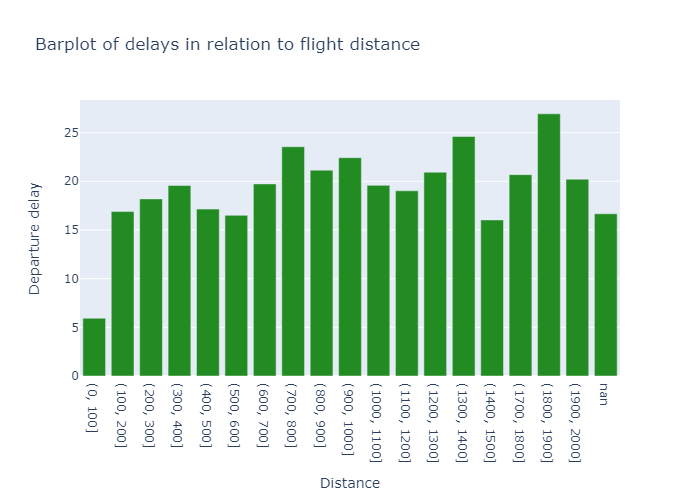

In [91]:
fig_distance_delay_agg = px.bar(flight_delays_by_distance_agg_df_grouped,
                      x='distance_agg',
                      y = 'is_delayed',
                      title='Barplot of delays in relation to flight distance',
                      color_discrete_sequence = ['forestgreen'])
fig_distance_delay_agg.update_layout(xaxis_title="Distance", yaxis_title="Departure delay")
fig_distance_delay_agg.show('png')

Flight distance have only slight influence on flight delay

 # Delays vs distance group (column that was in a dataframe by default)

 In this section analysis is made based on a column 'distance group' and delays in each of them 

Determining range of each group

In [92]:
flight_distance_by_distance_group = flight_df.groupby('distance_group').agg(['min', 'max']).reset_index()

flight_distance_by_distance_group = flight_distance_by_distance_group.loc[:,['distance_group', 'distance']]
flight_distance_by_distance_group

distance_group distance        
                      min     max
0              1    100.0   239.0
1              2    255.0   480.0
2              3    544.0   746.0
3              4    762.0   967.0
4              5   1024.0  1235.0
5              6   1389.0  1448.0
6              7   1721.0  1744.0
7              8   1846.0  1947.0
8             10   2475.0  2475.0

Grouping delays_ratio per distance group

In [93]:
flight_delays_by_distance_group_df = flight_df.loc[:, ['distance_group', 'is_delayed']]

flight_delays_by_distance_group_df = flight_delays_by_distance_group_df.groupby('distance_group').mean().reset_index()
flight_delays_by_distance_group_df['is_delayed'] = round(flight_delays_by_distance_group_df['is_delayed'] * 100, 2)
flight_delays_by_distance_group_df

,distance_group,is_delayed
0,1,15.86
1,2,18.73
2,3,19.82
3,4,21.65
4,5,19.62
5,6,18.96
6,7,20.68
7,8,23.54
8,10,16.66


Creating barplot of delays per distance group

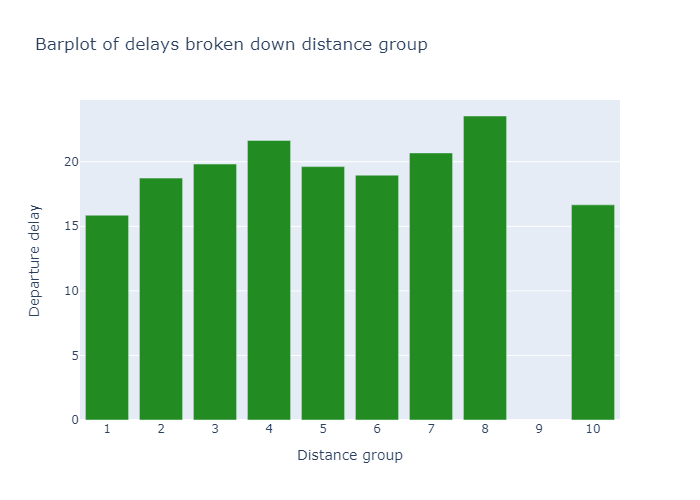

In [94]:
fig_dg_delay = px.bar(flight_delays_by_distance_group_df,
                      x='distance_group',
                      y = 'is_delayed',
                      title='Barplot of delays broken down distance group',
                      color_discrete_sequence = ['forestgreen'])
fig_dg_delay.update_layout(xaxis_title="Distance group", yaxis_title="Departure delay")
fig_dg_delay.update_xaxes(dtick = 'distance_group')
fig_dg_delay.show('png')

The last plot shows slight tendency that the longer the flight the longer the delay

Saving flight dataframe to pickle to retreive in the next notebook

In [95]:
flight_df.to_pickle(r'..\data\processed\flight_df_01.pk1')